In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
import tensorflow as tf
from sklearn.metrics import mean_squared_error
import keras_tuner as kt
from sklearn import metrics

In [2]:
df_insurance_claims = pd.read_csv("./Insurance_claims.csv")

## Data pre-processing before all models

In [3]:
df_insurance_claims["LossDate"] = pd.to_datetime(df_insurance_claims["LossDate"])
df_insurance_claims["FirstPolicySubscriptionDate"] = pd.to_datetime(df_insurance_claims["FirstPolicySubscriptionDate"])

In [4]:
df_insurance_claims["Days"] = df_insurance_claims["LossDate"] - df_insurance_claims["FirstPolicySubscriptionDate"]
df_insurance_claims["Days"] = pd.to_numeric(df_insurance_claims["Days"].dt.days, downcast='integer')
df_insurance_claims = df_insurance_claims.astype({"Days": "int64"})

In [5]:
df_insurance_claims

,ReferenceId,PolicyholderNumber,FirstPartyVehicleNumber,ThirdPartyVehicleNumber,InsurerNotes,PolicyholderOccupation,LossDate,FirstPolicySubscriptionDate,ClaimCause,ClaimInvolvedCovers,...,FpVehicleAgeMonths,EasinessToStage,ClaimWihoutIdentifiedThirdParty,ClaimAmount,LossHour,PolicyHolderAge,NumberOfBodilyInjuries,FirstPartyLiability,Fraud,Days
0,4842,531112,715507.0,NaN,avoids a cat and hits a garage pole With deduc...,CivilServant,2019-01-02,2018-06-18,CollisionWithAnimal,MaterialDamages ActLiability,...,104.0,0.25,1,4624.73,8.0,45.0,0,1.0,0,198
1,4844,87170,71164.0,NaN,accident only expert contacts us to inform us ...,Worker,2019-01-02,2017-06-29,LossOfControl,MaterialDamages ActLiability,...,230.0,0.50,1,1606.81,11.0,20.0,0,1.0,0,552
2,4848,98706,442609.0,NaN,ae Miss/ for garage change A/ setting up EAD/ ...,Worker,2019-01-02,2017-02-05,AccidentWithIdentifiedThirdParty,MaterialDamages ActLiability,...,93.0,0.25,0,998.20,18.0,32.0,0,0.5,0,696
3,4849,38240,24604.0,NaN,"awaiting report to determine rc, no box checke...",CivilServant,2019-01-02,2017-01-21,AccidentWithIdentifiedThirdParty,MaterialDamages ActLiability ReplacementVehicle,...,56.0,0.25,0,2506.92,11.0,46.0,0,0.5,0,711
4,4850,11339,2933.0,229134.0,Insured in THIRD-PARTY formula Insured in a su...,Farmer,2019-01-02,2018-01-13,AccidentWithIdentifiedThirdParty,ActLiability,...,110.0,0.25,0,12.00,12.0,28.0,0,0.0,0,354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11525,16378,452486,626487.0,NaN,NaN,Employee,2021-02-17,2019-03-15,WindscreenDamage,Windscreen,...,85.0,0.50,1,1010.23,0.0,56.0,0,0.0,0,705
11526,16379,581104,788178.0,NaN,NaN,Employee,2021-03-07,2017-07-20,WindscreenDamage,Windscreen,...,119.0,0.50,1,154.35,0.0,54.0,0,0.0,0,1326
11527,16380,817231,NaN,NaN,NaN,Employee,2021-03-15,2020-09-30,WindscreenDamage,Windscreen,...,139.0,0.50,1,420.25,0.0,34.0,0,0.0,0,166
11528,16381,321534,468522.0,NaN,NaN,CivilServant,2021-03-06,2018-12-28,WindscreenDamage,Windscreen,...,105.0,0.50,1,96.40,0.0,58.0,0,0.0,0,799


## Model 1: The Simple model based on the incident occurs within t days of the subscription date.
### Data Pre-processing

In [35]:
df_insurance_claims.head()

,ReferenceId,PolicyholderNumber,FirstPartyVehicleNumber,ThirdPartyVehicleNumber,InsurerNotes,PolicyholderOccupation,LossDate,FirstPolicySubscriptionDate,ClaimCause,ClaimInvolvedCovers,...,FpVehicleAgeMonths,EasinessToStage,ClaimWihoutIdentifiedThirdParty,ClaimAmount,LossHour,PolicyHolderAge,NumberOfBodilyInjuries,FirstPartyLiability,Fraud,Days
0,4842,531112,715507.0,NaN,avoids a cat and hits a garage pole With deduc...,CivilServant,2019-01-02,2018-06-18,CollisionWithAnimal,MaterialDamages ActLiability,...,104.0,0.25,1,4624.73,8.0,45.0,0,1.0,0,198
1,4844,87170,71164.0,NaN,accident only expert contacts us to inform us ...,Worker,2019-01-02,2017-06-29,LossOfControl,MaterialDamages ActLiability,...,230.0,0.50,1,1606.81,11.0,20.0,0,1.0,0,552
2,4848,98706,442609.0,NaN,ae Miss/ for garage change A/ setting up EAD/ ...,Worker,2019-01-02,2017-02-05,AccidentWithIdentifiedThirdParty,MaterialDamages ActLiability,...,93.0,0.25,0,998.20,18.0,32.0,0,0.5,0,696
3,4849,38240,24604.0,NaN,"awaiting report to determine rc, no box checke...",CivilServant,2019-01-02,2017-01-21,AccidentWithIdentifiedThirdParty,MaterialDamages ActLiability ReplacementVehicle,...,56.0,0.25,0,2506.92,11.0,46.0,0,0.5,0,711
4,4850,11339,2933.0,229134.0,Insured in THIRD-PARTY formula Insured in a su...,Farmer,2019-01-02,2018-01-13,AccidentWithIdentifiedThirdParty,ActLiability,...,110.0,0.25,0,12.00,12.0,28.0,0,0.0,0,354


In [36]:
# Check the missing values for each column
df_insurance_claims.isna().sum()

ReferenceId                            0
PolicyholderNumber                     0
FirstPartyVehicleNumber              495
ThirdPartyVehicleNumber            11151
InsurerNotes                        2357
PolicyholderOccupation               343
LossDate                               0
FirstPolicySubscriptionDate            0
ClaimCause                           197
ClaimInvolvedCovers                  195
DamageImportance                   10792
FirstPartyVehicleType                 12
ConnectionBetweenParties           11432
LossPostCode                        1408
PolicyHolderPostCode                   0
PolicyWasSubscribedOnInternet          0
NumberOfPoliciesOfPolicyholder         0
FpVehicleAgeMonths                    12
EasinessToStage                        0
ClaimWihoutIdentifiedThirdParty        0
ClaimAmount                            0
LossHour                              94
PolicyHolderAge                       36
NumberOfBodilyInjuries                 0
FirstPartyLiabil

In [37]:
# Check the unique values for each column
df_insurance_claims.nunique()

ReferenceId                        11530
PolicyholderNumber                  9404
FirstPartyVehicleNumber             9431
ThirdPartyVehicleNumber              350
InsurerNotes                        9040
PolicyholderOccupation                11
LossDate                             804
FirstPolicySubscriptionDate         1389
ClaimCause                            18
ClaimInvolvedCovers                   68
DamageImportance                       2
FirstPartyVehicleType                  4
ConnectionBetweenParties               5
LossPostCode                        3004
PolicyHolderPostCode                3130
PolicyWasSubscribedOnInternet          2
NumberOfPoliciesOfPolicyholder        17
FpVehicleAgeMonths                   388
EasinessToStage                        4
ClaimWihoutIdentifiedThirdParty        2
ClaimAmount                         8248
LossHour                              24
PolicyHolderAge                       73
NumberOfBodilyInjuries                 6
FirstPartyLiabil

#### For the model 1, we want to find out which claims are suspicious if the incident occurs within t days of subscription date. Therefore, we only need columns:
- FirstPolicySubscriptionDate
- LossDate
- Days
- Fraud

In [38]:
df_insurance_claims_model_1 = df_insurance_claims[["LossDate", "FirstPolicySubscriptionDate", "Days", "Fraud"]]
df_insurance_claims_model_1

,LossDate,FirstPolicySubscriptionDate,Days,Fraud
0,2019-01-02,2018-06-18,198,0
1,2019-01-02,2017-06-29,552,0
2,2019-01-02,2017-02-05,696,0
3,2019-01-02,2017-01-21,711,0
4,2019-01-02,2018-01-13,354,0
...,...,...,...,...
11525,2021-02-17,2019-03-15,705,0
11526,2021-03-07,2017-07-20,1326,0
11527,2021-03-15,2020-09-30,166,0
11528,2021-03-06,2018-12-28,799,0


In [39]:
df_insurance_claims_model_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11530 entries, 0 to 11529
Data columns (total 4 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   LossDate                     11530 non-null  datetime64[ns]
 1   FirstPolicySubscriptionDate  11530 non-null  datetime64[ns]
 2   Days                         11530 non-null  int64         
 3   Fraud                        11530 non-null  int64         
dtypes: datetime64[ns](2), int64(2)
memory usage: 360.4 KB


#### Determine the range of the t days

In [11]:
df_fraud = df_insurance_claims_model_1.loc[df_insurance_claims_model_1["Fraud"] == 1]

In [12]:
# The maximum value of t
df_fraud["Days"].max()

1201

In [13]:
# The minimum value of t
df_fraud["Days"].min()

0

In [14]:
# Set up the range of t days
t = range(1202)

#### We calculated the detection rate and hit rate based on the each t days
- The calculation formula of detection rate is:
$$
  Detection\ Rate =\frac{The\ Number\ of\ Detection}{Total\ Number\ of\ Observation}\, *100\%
$$
- The calculation formula of hit rate is:
$$
  Hit\ Rate =\frac{The\ Number\ of\ Real\ Fraud}{The\ Number\ of\ Detection}\, *100\%
$$


In [15]:
def detect_fraudulent_claims_model_1(t, df_datasets):
    
    # All_detection rate
    d = []
    # All hit rate
    h = []
    # All predictions 
    Y_all_prediction = []
    
    for i in t:
        # All prediction based on each t
        y_prediction = []
        # The number of detection
        a = 0
        # The number of real fraud
        b = 0
        
        for o in range(len(df_datasets)):
            if df_datasets["Days"][o] <= i:
                a = a + 1
                y = 1
                y_prediction.append(y)
                if df_datasets["Fraud"][o] == 1:
                    b = b + 1
            else:
                y = 0
                y_prediction.append(y)
        
        detection_rate = round((a / len(df_datasets))*100, 2)
        d.append(detection_rate)
        hit_rate = round((b / a)*100, 2)
        h.append(hit_rate)
        
        Y_all_prediction.append(y_prediction)

    
    return d, h, Y_all_prediction

In [16]:
d, h, Y_all_prediction = detect_fraudulent_claims_model_1(t, df_insurance_claims_model_1)

### The hit rate and detection rate of this model for different values of t are:

#### The hit rate (from t equals 0 to 1201)

In [17]:
h

[34.15,
 24.66,
 28.85,
 26.45,
 23.46,
 22.34,
 21.7,
 20.38,
 19.23,
 18.81,
 18.73,
 18.45,
 17.08,
 16.27,
 16.5,
 16.04,
 15.87,
 15.63,
 15.54,
 15.31,
 14.86,
 14.31,
 14.21,
 14.04,
 14.09,
 13.87,
 13.65,
 13.4,
 13.29,
 13.16,
 12.73,
 12.47,
 12.24,
 12.05,
 11.83,
 11.64,
 11.46,
 11.24,
 11.07,
 10.86,
 10.65,
 10.48,
 10.34,
 10.18,
 9.99,
 9.83,
 9.67,
 9.58,
 9.44,
 9.26,
 9.11,
 8.97,
 8.83,
 8.73,
 8.63,
 8.52,
 8.39,
 8.23,
 8.12,
 8.01,
 7.91,
 7.82,
 7.76,
 7.65,
 7.56,
 7.44,
 7.34,
 7.23,
 7.17,
 7.09,
 7.1,
 7.08,
 7.0,
 6.92,
 6.85,
 6.79,
 6.7,
 6.63,
 6.58,
 6.5,
 6.45,
 6.37,
 6.32,
 6.26,
 6.2,
 6.15,
 6.11,
 6.05,
 5.99,
 5.92,
 5.86,
 5.81,
 5.75,
 5.7,
 5.64,
 5.59,
 5.56,
 5.53,
 5.49,
 5.45,
 5.41,
 5.37,
 5.33,
 5.3,
 5.27,
 5.22,
 5.16,
 5.13,
 5.1,
 5.07,
 5.04,
 5.01,
 4.98,
 4.96,
 4.92,
 4.89,
 4.88,
 4.84,
 4.81,
 4.8,
 4.77,
 4.76,
 4.73,
 4.7,
 4.66,
 4.63,
 4.6,
 4.57,
 4.53,
 4.49,
 4.47,
 4.44,
 4.41,
 4.39,
 4.37,
 4.35,
 4.32,
 4.3,
 4.29

#### The detection rate (from t equals 0 to 1201)

In [18]:
d

[0.36,
 0.63,
 0.9,
 1.05,
 1.41,
 1.71,
 2.04,
 2.25,
 2.48,
 2.63,
 2.73,
 2.91,
 3.15,
 3.3,
 3.52,
 3.68,
 3.82,
 4.05,
 4.24,
 4.36,
 4.55,
 4.73,
 4.88,
 5.07,
 5.17,
 5.32,
 5.46,
 5.57,
 5.74,
 5.93,
 6.13,
 6.26,
 6.37,
 6.48,
 6.6,
 6.7,
 6.81,
 6.95,
 7.05,
 7.19,
 7.33,
 7.45,
 7.55,
 7.67,
 7.81,
 7.94,
 8.07,
 8.24,
 8.36,
 8.53,
 8.66,
 8.8,
 8.93,
 9.04,
 9.15,
 9.26,
 9.4,
 9.59,
 9.72,
 9.85,
 9.98,
 10.09,
 10.17,
 10.31,
 10.44,
 10.61,
 10.75,
 10.91,
 11.01,
 11.14,
 11.24,
 11.39,
 11.52,
 11.65,
 11.78,
 11.88,
 12.05,
 12.16,
 12.26,
 12.4,
 12.51,
 12.65,
 12.77,
 12.89,
 13.0,
 13.1,
 13.21,
 13.33,
 13.46,
 13.62,
 13.77,
 13.89,
 14.03,
 14.15,
 14.29,
 14.43,
 14.51,
 14.58,
 14.7,
 14.8,
 14.92,
 15.01,
 15.13,
 15.23,
 15.31,
 15.45,
 15.63,
 15.72,
 15.8,
 15.91,
 16.0,
 16.09,
 16.18,
 16.26,
 16.39,
 16.49,
 16.54,
 16.65,
 16.76,
 16.8,
 16.9,
 16.95,
 17.05,
 17.16,
 17.29,
 17.42,
 17.55,
 17.66,
 17.81,
 17.94,
 18.05,
 18.17,
 18.28,
 18.37,
 18.

### Plot the results of detection rate and hit rate

Text(0, 0.5, 'Hit Rate')

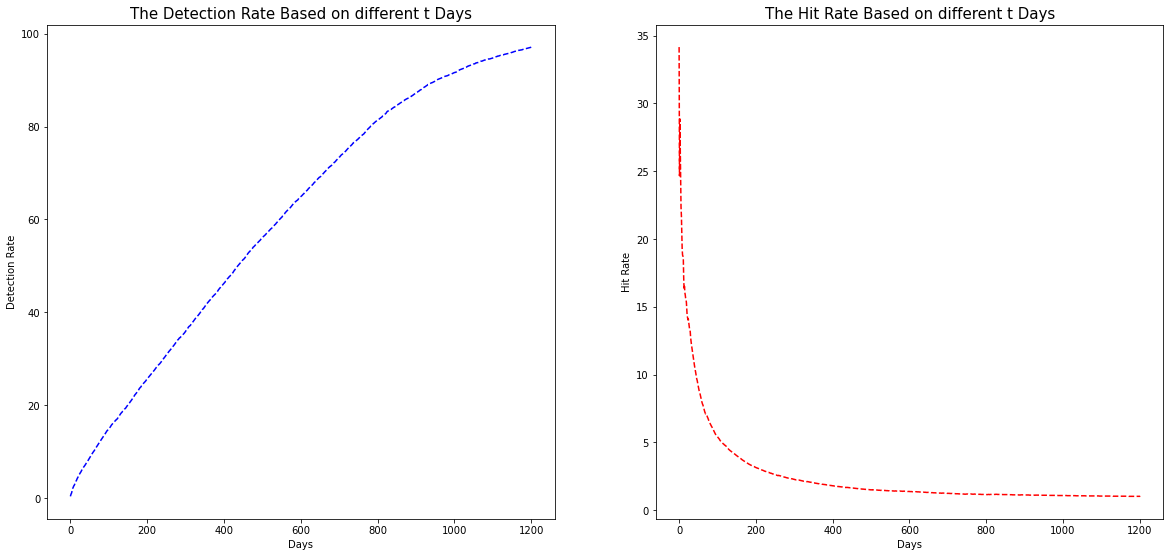

In [19]:
fig = plt.figure(figsize = (20, 20))
AX1 = fig.add_subplot(2,2,1)
AX2 = fig.add_subplot(2,2,2)

AX1.plot(t, d, ls = "--", color = "blue")
AX2.plot(t, h, ls = "--", color = "red")

AX1.set_title("The Detection Rate Based on different t Days", fontsize = 15, horizontalalignment="center")
AX2.set_title("The Hit Rate Based on different t Days", fontsize = 15, horizontalalignment="center")

AX1.set_xlabel("Days", fontsize = 10)
AX1.set_ylabel("Detection Rate", fontsize = 10)

AX2.set_xlabel("Days", fontsize = 10)
AX2.set_ylabel("Hit Rate", fontsize = 10)

In order to choose a sensible value of t, we used Receiver Operating Characteristic(ROC) accuracy to evaluate which t is the sensible one. 

A large ROC accuracy indicates that this model with a specific t is able to accurately identify suspicious claims while minimizing the number of false positives. 

- The calculation formula of ROC accuracy is:

$$
  ROC\ Accuracy =\frac{TP\ +\ TN}{TP\ +\ TN\ +\ FP\ +\ FN}
$$


In [211]:
def get_all_roc_accuracy(y, y_hat):
    all_roc_acc = []
    for i in range(len(y_hat)):
        roc_acc = round(metrics.roc_auc_score(y, y_hat[i]), 2)
        all_roc_acc.append(roc_acc)
    return all_roc_acc

In [170]:
all_roc_acc = get_all_roc_accuracy(df_insurance_claims_model_1["Fraud"], Y_all_prediction)

#### The ROC accuracy of the model (from t equals 0 to 1201)

In [171]:
all_roc_acc

[0.56,
 0.58,
 0.63,
 0.64,
 0.66,
 0.68,
 0.71,
 0.72,
 0.73,
 0.74,
 0.75,
 0.76,
 0.76,
 0.76,
 0.78,
 0.78,
 0.79,
 0.8,
 0.81,
 0.82,
 0.82,
 0.82,
 0.83,
 0.83,
 0.84,
 0.85,
 0.85,
 0.85,
 0.86,
 0.87,
 0.86,
 0.86,
 0.86,
 0.86,
 0.86,
 0.86,
 0.86,
 0.86,
 0.86,
 0.86,
 0.86,
 0.86,
 0.86,
 0.86,
 0.86,
 0.86,
 0.85,
 0.86,
 0.86,
 0.86,
 0.86,
 0.86,
 0.85,
 0.85,
 0.85,
 0.85,
 0.85,
 0.85,
 0.85,
 0.85,
 0.85,
 0.85,
 0.85,
 0.85,
 0.85,
 0.85,
 0.85,
 0.84,
 0.84,
 0.84,
 0.85,
 0.85,
 0.85,
 0.85,
 0.85,
 0.85,
 0.85,
 0.85,
 0.85,
 0.85,
 0.85,
 0.84,
 0.84,
 0.84,
 0.84,
 0.84,
 0.84,
 0.84,
 0.84,
 0.84,
 0.84,
 0.84,
 0.84,
 0.84,
 0.84,
 0.84,
 0.84,
 0.83,
 0.83,
 0.83,
 0.83,
 0.83,
 0.83,
 0.83,
 0.83,
 0.83,
 0.83,
 0.83,
 0.83,
 0.83,
 0.83,
 0.83,
 0.83,
 0.83,
 0.83,
 0.83,
 0.82,
 0.82,
 0.82,
 0.82,
 0.82,
 0.82,
 0.82,
 0.82,
 0.82,
 0.82,
 0.82,
 0.82,
 0.82,
 0.82,
 0.82,
 0.82,
 0.82,
 0.82,
 0.82,
 0.81,
 0.81,
 0.81,
 0.81,
 0.81,
 0.81,
 0.81,
 0.81,


### Plot the ROC accuracy based on each t days

Text(0, 0.5, 'ROC accuracy')

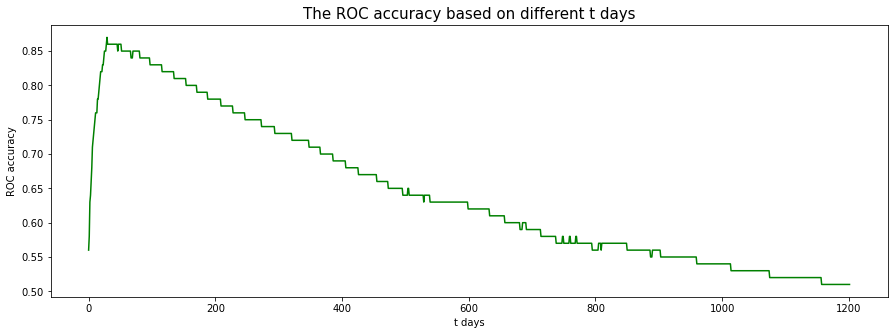

In [172]:
fig = plt.figure(figsize = (15, 5))
AX1 = fig.add_subplot(1,1,1)

AX1.plot(t, all_roc_acc, ls = "-", color = "green")

AX1.set_title("The ROC accuracy based on different t days", fontsize = 15, horizontalalignment="center")

AX1.set_xlabel("t days", fontsize = 10)
AX1.set_ylabel("ROC accuracy", fontsize = 10)


### Find out the sensible t based on Roc accuracy

In [173]:
for i in range(len(all_roc_acc)):
    if all_roc_acc[i] == max(all_roc_acc):
        print("The sensible t is " + str(i))
        print("The detection rate is " + str(d[i]) + "%")
        print("The hit rate is " + str(h[i]) + "%")
        print("The ROC accuracy of the model is " + str(all_roc_acc[i]))

The sensible t is 29
The detection rate is 5.93%
The hit rate is 13.16%
The ROC accuracy of the model is 0.87


# Mention unbalance dataset and how to figure out this problem

# Add more information about F1 ！！！！

In [216]:
def get_all_F1_score(y, y_hat):
    F1_score = []
    for i in range(len(y_hat)):
        F1 = round(metrics.f1_score(y, y_hat[i]), 2)
        F1_score.append(F1)
    return F1_score

In [122]:
all_F1_score = get_all_F1_score(df_insurance_claims_model_1["Fraud"], Y_all_prediction)

#### The F1 score of the model (from t equals 0 to 1201)

In [123]:
all_F1_score

[0.18,
 0.19,
 0.27,
 0.27,
 0.27,
 0.28,
 0.29,
 0.28,
 0.27,
 0.27,
 0.27,
 0.27,
 0.26,
 0.25,
 0.26,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.24,
 0.24,
 0.24,
 0.23,
 0.24,
 0.23,
 0.23,
 0.23,
 0.23,
 0.23,
 0.22,
 0.22,
 0.21,
 0.21,
 0.21,
 0.2,
 0.2,
 0.2,
 0.19,
 0.19,
 0.19,
 0.18,
 0.18,
 0.18,
 0.18,
 0.17,
 0.17,
 0.17,
 0.17,
 0.17,
 0.16,
 0.16,
 0.16,
 0.16,
 0.16,
 0.15,
 0.15,
 0.15,
 0.15,
 0.15,
 0.14,
 0.14,
 0.14,
 0.14,
 0.14,
 0.14,
 0.13,
 0.13,
 0.13,
 0.13,
 0.13,
 0.13,
 0.13,
 0.13,
 0.13,
 0.13,
 0.12,
 0.12,
 0.12,
 0.12,
 0.12,
 0.12,
 0.12,
 0.12,
 0.12,
 0.11,
 0.11,
 0.11,
 0.11,
 0.11,
 0.11,
 0.11,
 0.11,
 0.11,
 0.11,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.09,
 0.09,
 0.09,
 0.09,
 0.09,
 0.09,
 0.09,
 0.09,
 0.09,
 0.09,
 0.09,
 0.09,
 0.09,
 0.09,
 0.09,
 0.09,
 0.09,
 0.09,
 0.09,
 0.09,
 0.08,
 0.08,
 0.08,
 0.08,
 0.08,
 0.08,
 0.08,
 0.08,
 0.08,
 0.08,
 0.08,
 0.08,
 0.08,
 0.08,
 0.08,
 0.

### Plot the F1 score based on each t days

Text(0, 0.5, 'F1 score')

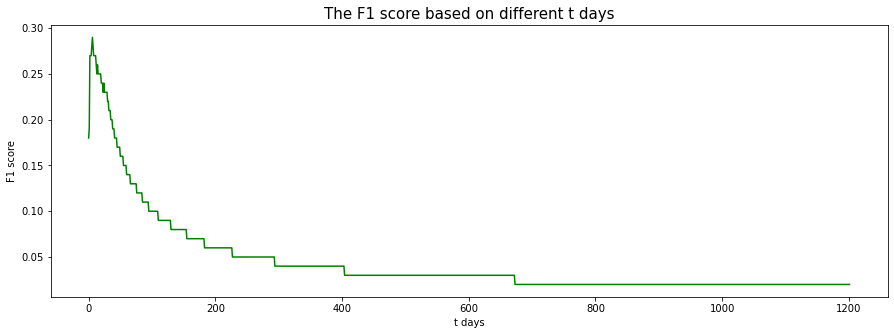

In [124]:
fig = plt.figure(figsize = (15, 5))
AX1 = fig.add_subplot(1,1,1)

AX1.plot(t, all_F1_score, ls = "-", color = "green")

AX1.set_title("The F1 score based on different t days", fontsize = 15, horizontalalignment="center")

AX1.set_xlabel("t days", fontsize = 10)
AX1.set_ylabel("F1 score", fontsize = 10)


### Find out the sensible t of this model

In [126]:
for i in range(len(all_F1_score)):
    if all_F1_score[i] == max(all_F1_score):
        print("The sensible t is " + str(i))
        print("The detection rate is " + str(d[i]) + "%")
        print("The hit rate is " + str(h[i]) + "%")
        print("The F1 score of the model is " + str(all_F1_score[i]))

The sensible t is 6
The detection rate is 2.04%
The hit rate is 21.7%
The F1 score of the model is 0.29


### The logic underlies this model and its bias

The logic underlying this model is that when a customer subscribes to a service, it is more likely that fraudulent claims will be made shortly after the subscription date. Therefore, by setting a threshold for how soon a claim can be made after the subscription date, it is possible to identify suspicious claims. This threshold can then be adjusted to find a balance between the hit rate and detection rate for the model.


However, this model has the potential to discriminate against customers who make claims shortly after subscribing to a service, as these claims will be flagged as suspicious regardless of their validity. That would damage the customers' trust relationship with the company. Additionally, if the threshold is set too low, then the model may also falsely flag legitimate claims as suspicious.

## Model 4: Neural Network Model

### Data pre-processing 

In [6]:
# Remove the columns that have too many missing values and unnecessary comlumns such as Reference ID, PolicyHolderPostcode
df_insurance_claims_model_4 = df_insurance_claims.drop(columns = ["ReferenceId", 
                                                                  "PolicyholderNumber", 
                                                                  "FirstPartyVehicleNumber",
                                                                  "ThirdPartyVehicleNumber",
                                                                  "InsurerNotes",
                                                                  "DamageImportance",
                                                                  "ConnectionBetweenParties",
                                                                  "LossPostCode",
                                                                  "PolicyHolderPostCode",
                                                                  "LossDate",
                                                                  "FirstPolicySubscriptionDate"
                                                                 ])

In [7]:
# Removing the mising values
df_insurance_claims_model_4 = df_insurance_claims_model_4[(df_insurance_claims_model_4.PolicyholderOccupation.notnull()) &
                                                          (df_insurance_claims_model_4.ClaimCause.notnull()) &
                                                          (df_insurance_claims_model_4.ClaimInvolvedCovers.notnull()) &
                                                          (df_insurance_claims_model_4.FirstPartyVehicleType.notnull()) &
                                                          (df_insurance_claims_model_4.FpVehicleAgeMonths.notnull()) &
                                                          (df_insurance_claims_model_4.LossHour.notnull()) &
                                                          (df_insurance_claims_model_4.PolicyHolderAge.notnull())
                                                          ].reset_index()

In [8]:
# Change the object variables to the category variables
df_insurance_claims_model_4["PolicyholderOccupation"] = pd.factorize(df_insurance_claims_model_4.PolicyholderOccupation)[0]
df_insurance_claims_model_4["ClaimCause"] = pd.factorize(df_insurance_claims_model_4.ClaimCause)[0]
df_insurance_claims_model_4["ClaimInvolvedCovers"] = pd.factorize(df_insurance_claims_model_4.ClaimInvolvedCovers)[0]
df_insurance_claims_model_4["FirstPartyVehicleType"] = pd.factorize(df_insurance_claims_model_4.FirstPartyVehicleType)[0]

In [9]:
df_insurance_claims_model_4 = df_insurance_claims_model_4.drop(columns = ["index"])
df_insurance_claims_model_4

,PolicyholderOccupation,ClaimCause,ClaimInvolvedCovers,FirstPartyVehicleType,PolicyWasSubscribedOnInternet,NumberOfPoliciesOfPolicyholder,FpVehicleAgeMonths,EasinessToStage,ClaimWihoutIdentifiedThirdParty,ClaimAmount,LossHour,PolicyHolderAge,NumberOfBodilyInjuries,FirstPartyLiability,Fraud,Days
0,0,0,0,0,1,1,104.0,0.25,1,4624.73,8.0,45.0,0,1.0,0,198
1,1,1,0,0,0,3,230.0,0.50,1,1606.81,11.0,20.0,0,1.0,0,552
2,1,2,0,0,0,9,93.0,0.25,0,998.20,18.0,32.0,0,0.5,0,696
3,0,2,1,0,0,2,56.0,0.25,0,2506.92,11.0,46.0,0,0.5,0,711
4,2,2,2,0,0,4,110.0,0.25,0,12.00,12.0,28.0,0,0.0,0,354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10889,3,3,3,0,0,1,85.0,0.50,1,1010.23,0.0,56.0,0,0.0,0,705
10890,3,3,3,0,0,3,119.0,0.50,1,154.35,0.0,54.0,0,0.0,0,1326
10891,3,3,3,0,0,4,139.0,0.50,1,420.25,0.0,34.0,0,0.0,0,166
10892,0,3,3,0,0,6,105.0,0.50,1,96.40,0.0,58.0,0,0.0,0,799


In [10]:
# Reset the index of the columns
df_insurance_claims_model_4 = df_insurance_claims_model_4.reindex(["PolicyholderOccupation",
                                                                   "ClaimCause",
                                                                   "ClaimInvolvedCovers",
                                                                   "FirstPartyVehicleType",
                                                                   "PolicyWasSubscribedOnInternet",
                                                                   "NumberOfPoliciesOfPolicyholder",
                                                                   "FpVehicleAgeMonths",
                                                                   "EasinessToStage",
                                                                   "ClaimWihoutIdentifiedThirdParty",
                                                                   "ClaimAmount",
                                                                   "LossHour",
                                                                   "PolicyHolderAge",
                                                                   "NumberOfBodilyInjuries",
                                                                   "FirstPartyLiability",
                                                                   "Days",
                                                                   "Fraud"], axis=1)

In [11]:
df_insurance_claims_model_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10894 entries, 0 to 10893
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   PolicyholderOccupation           10894 non-null  int64  
 1   ClaimCause                       10894 non-null  int64  
 2   ClaimInvolvedCovers              10894 non-null  int64  
 3   FirstPartyVehicleType            10894 non-null  int64  
 4   PolicyWasSubscribedOnInternet    10894 non-null  int64  
 5   NumberOfPoliciesOfPolicyholder   10894 non-null  int64  
 6   FpVehicleAgeMonths               10894 non-null  float64
 7   EasinessToStage                  10894 non-null  float64
 8   ClaimWihoutIdentifiedThirdParty  10894 non-null  int64  
 9   ClaimAmount                      10894 non-null  float64
 10  LossHour                         10894 non-null  float64
 11  PolicyHolderAge                  10894 non-null  float64
 12  NumberOfBodilyInju

#### Build up the Neural Network Model

In [12]:
tf.keras.backend.clear_session()
np.random.seed(121)
tf.random.set_seed(111)

In [13]:
# Set up the input and output of the model
X = df_insurance_claims_model_4.iloc[:,0:15]
y = df_insurance_claims_model_4.iloc[:,15]

In [14]:
# Separate the data into training/validation/testing with percentages 60%/20%/20%
X_train, X_other, y_train, y_other = train_test_split(X, y, train_size=0.6, random_state=120)
X_test, X_valid, y_test, y_valid = train_test_split(X_other, y_other, train_size = 0.5, random_state=123)

In [15]:
# Standardize the input data value into a standard format
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [ ]:
# Number of units: Needs to be large. 64, 128, and 256 are all sensible choics
# batch norm seems to yields better performance than dropout
# Number of hidden layers: at least 2 because it's a deep neural network

In [157]:
def nerual_network_model(hp):
    num_units = hp.Choice('num_units', [64, 128]) 
    dropout_rate = hp.Float('dropout_rate', min_value = 0.1, max_value = 0.3)
    learning_rate = hp.Float('learning_rate', min_value = 0.01, max_value = 0.1, sampling = 'log')
    
    model = tf.keras.models.Sequential([
        # tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(num_units, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        # tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(num_units, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.experimental.Adam(learning_rate = learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )
                
    return model

In [158]:
# Find the optimal parameters for the model
tuner = kt.Hyperband(nerual_network_model,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='logs',
                     project_name='Nlll',
                     overwrite=True)

In [159]:
tuner.search(X_train, y_train, validation_data=(X_valid,y_valid))

Trial 30 Complete [00h 00m 14s]
val_loss: 0.05484815314412117

Best val_loss So Far: 0.05229309946298599
Total elapsed time: 00h 02m 53s
INFO:tensorflow:Oracle triggered exit


In [160]:
best_hps = tuner.get_best_hyperparameters()[0]
print("Best number of hidden units:", best_hps['num_units'])
print("Best dropout rate:", best_hps['dropout_rate'])
print("Best learning rate:", best_hps['learning_rate'])

Best number of hidden units: 64
Best dropout rate: 0.18692862817077632
Best learning rate: 0.01821291476410426


In [161]:
best_model = tuner.hypermodel.build(best_hps)

In [162]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True
)

In [163]:
log = best_model.fit(X_train, y_train, epochs=30, batch_size = 64, validation_data=(X_valid,y_valid), callbacks=[early_stopping_cb])

Epoch 1/30
103/103 [==============================] - 2s 8ms/step - loss: 0.1078 - accuracy: 0.9703 - auc_1: 0.6194 - val_loss: 0.0712 - val_accuracy: 0.9872 - val_auc_1: 0.7004
Epoch 2/30
103/103 [==============================] - 0s 5ms/step - loss: 0.0418 - accuracy: 0.9914 - auc_1: 0.8067 - val_loss: 0.0591 - val_accuracy: 0.9872 - val_auc_1: 0.7729
Epoch 3/30
103/103 [==============================] - 0s 4ms/step - loss: 0.0388 - accuracy: 0.9913 - auc_1: 0.8689 - val_loss: 0.0744 - val_accuracy: 0.9872 - val_auc_1: 0.6645
Epoch 4/30
103/103 [==============================] - 0s 4ms/step - loss: 0.0391 - accuracy: 0.9916 - auc_1: 0.8591 - val_loss: 0.0609 - val_accuracy: 0.9872 - val_auc_1: 0.7927
Epoch 5/30
103/103 [==============================] - 0s 4ms/step - loss: 0.0378 - accuracy: 0.9916 - auc_1: 0.8622 - val_loss: 0.0566 - val_accuracy: 0.9867 - val_auc_1: 0.8546
Epoch 6/30
103/103 [==============================] - 1s 6ms/step - loss: 0.0349 - accuracy: 0.9913 - auc_1: 0

In [164]:
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                1024      
                                                                 
 batch_normalization_2 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 batch_normalization_3 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,761
Trainable params: 5,505
Non-traina

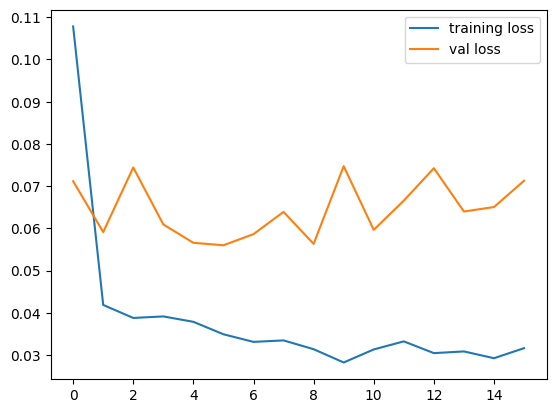

In [165]:
plt.plot(log.history['loss'],label = "training loss")
plt.plot(log.history['val_loss'], label = "val loss")
plt.legend()
plt.show()

Model is overfitting even though we've used batch normalisation or dropout which is supposed to address this. This is likely because the training dataset is not representative of the test set, which is quite common for imbalanced classification problems when the number of frauds is low. It's also possible that the size of the training dataset is not big enough to train a deep neural network.

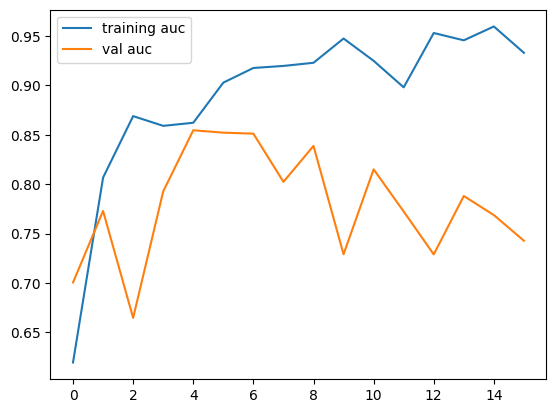

In [166]:
plt.plot(log.history['auc_1'],label = "training auc")
plt.plot(log.history['val_auc_1'], label = "val auc")
plt.legend()
plt.show()

#### Test the model

In [100]:
y_predict = best_model.predict(X_test)

69/69 [==============================] - 0s 2ms/step


In [101]:
len(y_predict)

2179

In [102]:
# set up the range of threshold
threshold = np.arange(0, 1, 0.01)

In [103]:
def predict(threshold, y_hat):
    all_y_prediction = []
    for i in range(len(threshold)):
        y_prediction = []
        for o in range(len(y_hat)):
            if y_hat[o] >= threshold[i]:
                y = 1
                y_prediction.append(y)
            else:
                y = 0
                y_prediction.append(y)
        all_y_prediction.append(y_prediction)
    return all_y_prediction

In [104]:
all_y_prediction = predict(threshold, y_predict)

In [105]:
len(all_y_prediction[1])

2179

In [106]:
def get_detection_rate_and_hit_rate_model_4(all_y_prediction, y_test):
    
    # All_detection rate
    d = []
    # All hit rate
    h = []
    
    for i in range(len(all_y_prediction)):
        
        # The number of detection
        a = 0
        # The number of real fraud
        b = 0
        
        for o, n in zip(all_y_prediction[i], y_test):
            if o == 1:
                a = a + 1
                if n == 1:
                    b = b + 1
            else:
                pass
            
        if a == 0:
            detection_rate = 0
            d.append(detection_rate)
            hit_rate = 0
            h.append(hit_rate)
        else:
            detection_rate = round((a / len(y_test))*100, 2)
            d.append(detection_rate)
            hit_rate = round((b / a)*100, 2)
            h.append(hit_rate)

    
    return d, h

In [107]:
model4_d, model4_h = get_detection_rate_and_hit_rate_model_4(all_y_prediction, y_test)

In [108]:
def get_all_roc_accuracy(y, y_hat):
    all_roc_acc = []
    for i in range(len(y_hat)):
        roc_acc = round(metrics.roc_auc_score(y, y_hat[i]), 2)
        all_roc_acc.append(roc_acc)
    return all_roc_acc

In [109]:
# ROC Accuracy
get_all_roc_accuracy = get_all_roc_accuracy(y_test, all_y_prediction)

Text(0, 0.5, 'ROC accuracy')

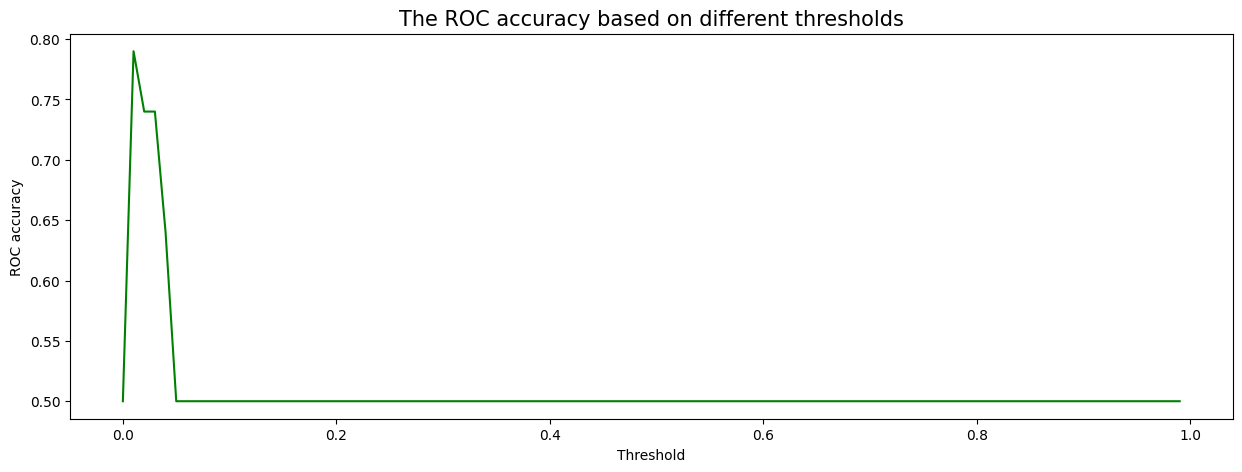

In [110]:
fig = plt.figure(figsize = (15, 5))
AX1 = fig.add_subplot(1,1,1)

AX1.plot(threshold, get_all_roc_accuracy, ls = "-", color = "green")

AX1.set_title("The ROC accuracy based on different thresholds", fontsize = 15, horizontalalignment="center")

AX1.set_xlabel("Threshold", fontsize = 10)
AX1.set_ylabel("ROC accuracy", fontsize = 10)

In [111]:
for i in range(len(get_all_roc_accuracy)):
    if get_all_roc_accuracy[i] == max(get_all_roc_accuracy):
        print("The threshold is " + str(threshold[i]))
        print("The detection rate is " + str(model4_d[i]) + "%")
        print("The hit rate is " + str(model4_h[i]) + "%")
        print("The ROC accuracy of the model is " + str(get_all_roc_accuracy[i]))

The threshold is 0.01
The detection rate is 27.08%
The hit rate is 3.73%
The ROC accuracy of the model is 0.79


In [112]:
def get_all_F1_score(y, y_hat):
    F1_score = []
    for i in range(len(y_hat)):
        F1 = round(metrics.f1_score(y, y_hat[i]), 2)
        F1_score.append(F1)
    return F1_score

In [113]:
# F1 score
get_all_F1_score = get_all_F1_score(y_test, all_y_prediction)

Text(0, 0.5, 'F1 score')

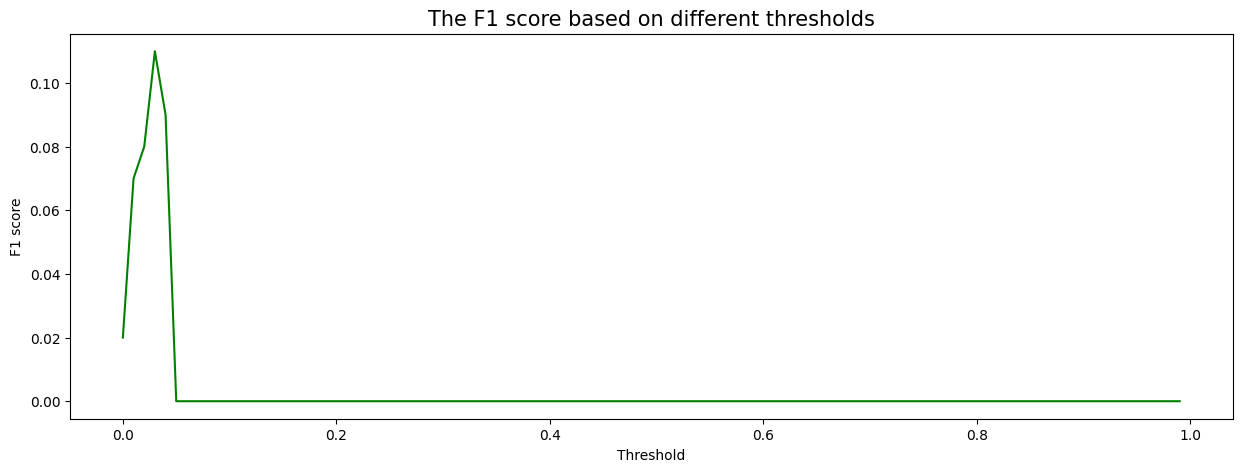

In [114]:
fig = plt.figure(figsize = (15, 5))
AX1 = fig.add_subplot(1,1,1)

AX1.plot(threshold, get_all_F1_score, ls = "-", color = "green")

AX1.set_title("The F1 score based on different thresholds", fontsize = 15, horizontalalignment="center")

AX1.set_xlabel("Threshold", fontsize = 10)
AX1.set_ylabel("F1 score", fontsize = 10)

In [115]:
for i in range(len(get_all_F1_score)):
    if get_all_F1_score[i] == max(get_all_F1_score):
        print("The threshold is " + str(threshold[i]))
        print("The detection rate is " + str(model4_d[i]) + "%")
        print("The hit rate is " + str(model4_h[i]) + "%")
        print("The F1 score of the model is " + str(get_all_F1_score[i]))

The threshold is 0.03
The detection rate is 11.06%
The hit rate is 6.22%
The F1 score of the model is 0.11


In [60]:
threshold[2:13]

array([0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11, 0.12])

In [61]:
model4_d[2:13]

[10.28, 7.43, 5.42, 3.81, 2.85, 1.79, 1.28, 1.1, 0.78, 0.69, 0.5]

In [62]:
model4_h[2:13]

[4.46, 5.56, 5.93, 6.02, 8.06, 10.26, 10.71, 12.5, 5.88, 6.67, 9.09]